# One-dimensional bandwidth sweep

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.scipy.stats import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import SVGD, get_bandwidth
from utils import dict_concatenate, dict_mean
from tqdm import tqdm

In [2]:
n=100
d=1
stepsize = 0.01
L = 300 # 100 slightly to little, this should be all right
grid_length = 50

from utils import log_gaussian_mixture
logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])

svgd_fix = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))
# bandwidth_grid = np.logspace(-10, 15, num=grid_length, base=2)
bandwidth_grid = np.linspace(0.4, 7, num=grid_length)
ksd_bandwidths = [0.1, 1, 10]
metric_names = ["MSE X", "MSE X^2"] +  [f"KSD {h}" for h in ksd_bandwidths]

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
from metrics import get_metrics

def sweep(rkey, grid, ksd_bandwidths):
    """Sweep a grid of bandwidth values and output corresponding metrics."""
    sweep_results = []
    for h in tqdm(grid):
        xout, _ = svgd_fix.svgd(rkey, stepsize, h, L)
        sweep_results.append(get_metrics(xout, logp, ksd_bandwidths))
    return np.array(sweep_results)

In [4]:
m = 10
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid, ksd_bandwidths)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)

  0%|          | 0/50 [00:00<?, ?it/s]

JIT COMPILING svgd...
...done compiling svgd after 0.5054969787597656 seconds.


100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


Then get the same metrics for the adaptive bandwidth:

In [5]:
adas = []
for _ in range(m):
    svgd_ada.newkey()
    xout, _ = svgd_ada.svgd(svgd_ada.rkey, stepsize, 0, L)
    metrics_ada = get_metrics(xout, logp, ksd_bandwidths)
    adas.append(metrics_ada)
adas = np.array(adas)
metrics_ada = np.mean(adas, axis=0)

JIT COMPILING svgd...
...done compiling svgd after 0.3722102642059326 seconds.


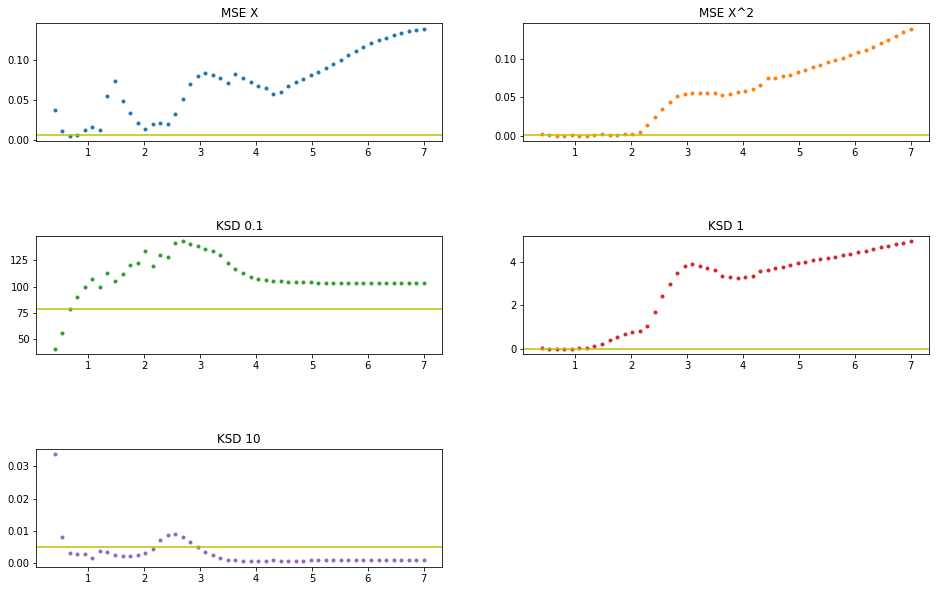

In [6]:
plt.figure(1, figsize=[16.0, 10.0])
plt.subplots_adjust(hspace=0.8)
col = plt.rcParams['axes.prop_cycle'].by_key()['color']
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    plt.plot(bandwidth_grid, sw, ".", color=col[i])
#     plt.xscale('log')
#     plt.yscale('log')
    
    plt.axhline(y=float(metrics_ada[i]), color="y")

# Two-dimensional bandwidth sweep

For bandwidth values $(h, h)$ with $h$ in the range $10-100$ we get very bad results: MSE and KSD values larger than $10^3$.

In [7]:
n=100
d=2
stepsize = 0.01
L = 400
grid_length = 25

In [8]:
from jax.scipy.stats import multivariate_normal

mean = np.array([1,2])
cov = np.array([[1,1], [1, 2]])
logp = lambda x: multivariate_normal.logpdf(x, mean, cov)

svgd_fix = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [9]:
from metrics import ksd
def get_metrics(xout, logp, ksd_bandwidths):
    """
    Compute metrics.
    """
    assert xout.ndim == 2
    assert xout.shape[1] == 2
    assert not np.any(np.isnan(xout))

    metrics = []
    # MSEs
    metrics.append(np.mean((np.mean(xout, axis=0)    - mean)**2)) # average the dimensions to get a scalar metric
#     metrics.append(np.mean((np.mean(xout**2, axis=0) - np.diag(cov))**2))
#     metrics.append(np.mean((np.mean(..., axis=1)   - ...)**2))
    
    #KSDs
    for ksd_bandwidth in ksd_bandwidths:
        metrics.append(ksd(xout, logp, ksd_bandwidth))
    return metrics

In [10]:
# bandwidth_grid = np.logspace(-3, 5, num=grid_length)
# bandwidth_grid = np.logspace(-0.5, 2, num=grid_length)
bandwidth_grid = np.linspace(0.3, 2.5, num=grid_length)
ksd_bandwidths = [0.5, 0.8, 1, 1.5, 2, 2.5]
metric_names = ["MSE X"] +  [f"KSD {h}" for h in ksd_bandwidths]


bandwidth_grid = np.tile(bandwidth_grid, (d, 1))
bandwidth_grid = np.transpose(bandwidth_grid)
bandwidth_grid.shape

(25, 2)

In [11]:
m = 5
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid, ksd_bandwidths)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)

  0%|          | 0/25 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 1.4743454456329346 seconds.


100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


In [12]:
assert not np.any(np.isnan(sweeps))

In [13]:
adas = []
for _ in tqdm(range(m)):
    svgd_ada.newkey()
    xout, _ = svgd_ada.svgd(svgd_ada.rkey, stepsize, 0, L)
    metrics_ada = get_metrics(xout, logp, ksd_bandwidths)
    adas.append(metrics_ada)
adas = np.array(adas)
metrics_ada = np.mean(adas, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 0.4099276065826416 seconds.


100%|██████████| 5/5 [00:49<00:00,  9.94s/it]


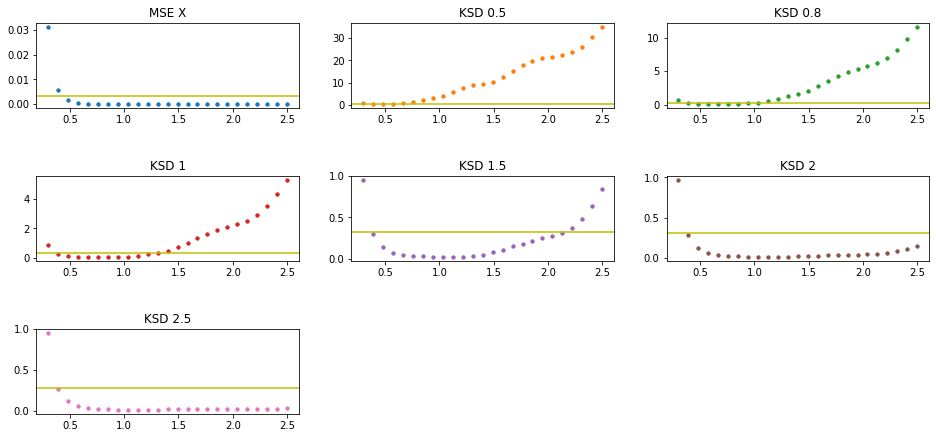

In [14]:
plt.figure(1, figsize=[16.0, 10.0])
plt.subplots_adjust(hspace=0.8)
col = plt.rcParams['axes.prop_cycle'].by_key()['color']
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    plt.plot(bandwidth_grid, sw, ".", color=col[i])
#     plt.xscale('log')
#     plt.yscale('log')
    plt.axhline(y=float(metrics_ada[i]), color="y")

## same thing for larger bandwidths

In [15]:
bandwidth_grid = np.linspace(2.5, 5, num=grid_length)
ksd_bandwidths = [2.5, 3, 3.5, 4, 4.5, 5]
metric_names = ["MSE X"] +  [f"KSD {h}" for h in ksd_bandwidths]


bandwidth_grid = np.tile(bandwidth_grid, (d, 1))
bandwidth_grid = np.transpose(bandwidth_grid)

m = 5
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid, ksd_bandwidths)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)
assert not np.any(np.isnan(sweeps))
sweeps1 = sweeps

adas = []
for _ in tqdm(range(m)):
    svgd_ada.newkey()
    xout, _ = svgd_ada.svgd(svgd_ada.rkey, stepsize, 0, L)
    metrics_ada = get_metrics(xout, logp, ksd_bandwidths)
    adas.append(metrics_ada)
adas = np.array(adas)
metrics_ada = np.mean(adas, axis=0)
metrics_ada1 = metrics_ada

100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


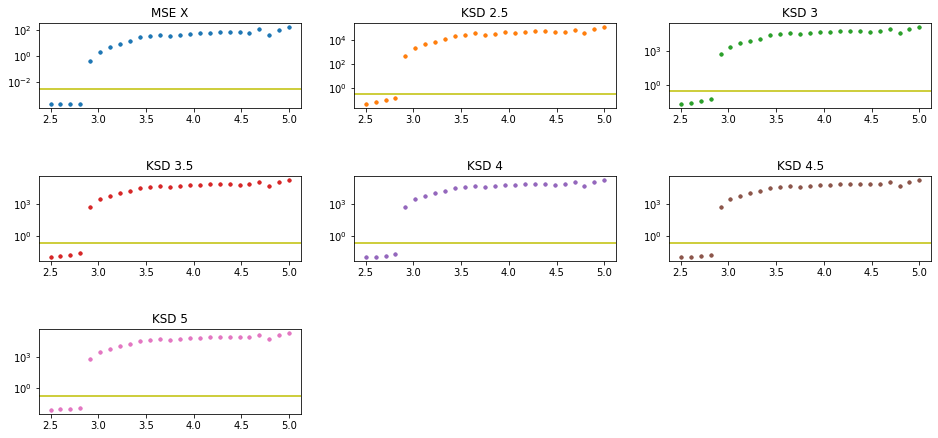

In [16]:
plt.figure(1, figsize=[16.0, 10.0])
plt.subplots_adjust(hspace=0.8)
col = plt.rcParams['axes.prop_cycle'].by_key()['color']
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps1):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    plt.plot(bandwidth_grid, sw, ".", color=col[i])
#     plt.xscale('log')
    plt.yscale('log')
    plt.axhline(y=float(metrics_ada1[i]), color="y")

## takeaways
* whichever way we measure it, kernel choice has large effect on accuracy
* the KSD measure with kernel parameter $h$ favours SVGD with same kernel parameter (it makes sense that this is the case, since SVGD minimizes the KL divergence in the space of distributions given by smooth transformations in the RKHS of the kernel with parameter $h$).
* this means that some measures are better than others. In particular, it is likely that choosing the right kernel for use in the KSD measure is not much easier than choosing the right kernel directly.

This leaves us with a few possibilities:
1. Hope that choosing a sufficiently good kernel for KSD is in fact easier than choosing the right kernel directly
2. Don't choose the KSD kernel parameter separately. Always use the same kernel for SVGD and for computing the loss.
3. Choose a different loss (e.g. find a way to approximate the KL divergence).

## Random grid search

In [17]:
grid_length = 100
rkey = random.PRNGKey(123)
scale = "linear"
if scale == "log":
    bandwidth_grid = random.uniform(rkey, shape=(grid_length, d)) * 2.5 - 0.5 #* 25 - 10
    bandwidth_grid = 10**bandwidth_grid
else:
    mi, ma = [0.3, 2.5]
    bandwidth_grid = random.uniform(rkey, shape=(grid_length, d)) * (ma - mi) + mi

In [18]:
m = 5
metrics_sweep = []
sweeps = []
for i in range(m):
#     print(f"Sweep {i+1} of {m}")
    svgd_fix.newkey()
    s = sweep(svgd_fix.rkey, bandwidth_grid, ksd_bandwidths)
    sweeps.append(s)
sweeps = np.array(sweeps)
sweeps = np.mean(sweeps, axis=0)
sweeps = np.transpose(sweeps) # (num_metrics, bandwidth_length)

100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


### Scatterplot

In [19]:
def scatter(grid, data):
#     plt.figure(1, figsize=[8, 8])
    x, y = grid.transpose()
    colors = data
    colors = np.log(colors)

    plt.scatter(x, y, s=100, c=colors)
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel("h1")
    plt.ylabel("h2")

    for i, v in enumerate(data):
        if i % 5 == 0:
            plt.annotate(v, (x[i], y[i]))

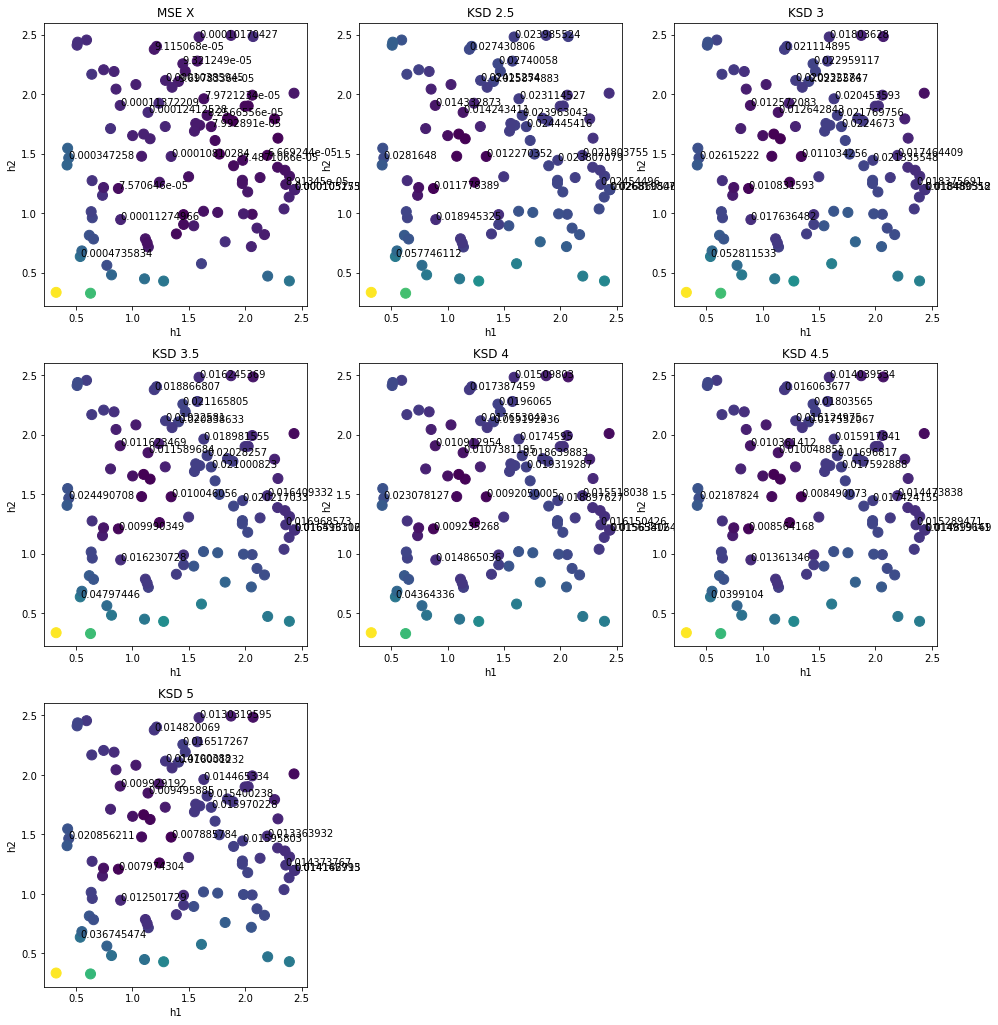

In [20]:
plt.figure(1, figsize=[16.0, 24.0])
# plt.subplots_adjust(hspace=0.8)
l = sweeps.shape[0]
k = l // 2

for i, sw in enumerate(sweeps):
    plt.subplot(f"{l-k}{k}{i+1}")
    plt.title(metric_names[i])
    scatter(bandwidth_grid, sweeps[i])
# scatter(bandwidth_grid, sweeps[2])
# plt.title(metric_names[2])